In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/45979/status,
Dashboard: /proxy/45979/status,Workers: 4
Total threads: 8,Total memory: 250.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41657,Workers: 4
Dashboard: /proxy/45979/status,Total threads: 8
Started: Just now,Total memory: 250.00 GiB
Comm: tcp://127.0.0.1:35781,Total threads: 2
Dashboard: /proxy/41381/status,Memory: 62.50 GiB
Nanny: tcp://127.0.0.1:44265,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')
mask = mask['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu']
hu = hu.sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90,-50.1,.1))), 1, np.nan)
land_ice_mask = land_ice_mask.interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, 
                                     land_ice_mask['lon'] + 360, 
                                     land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon':'_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj':sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj':'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_lin = xr.open_dataset('../data/smooth_div_line.nc')
div_lin = div_lin['__xarray_dataarray_variable__']

Load reanalysis and CMIP6 multimodel mean

In [ ]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas']
    uas[k] = uas[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas']
    vas[k] = vas[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl']
    psl[k] = psl[k].sel(time = slice('1979-01-01', '2015-01-01')).mean('time')

In [ ]:
wsp = {}
for k in keys:
    wsp[k] = np.sqrt(uas[k]**2 + vas[k]**2)

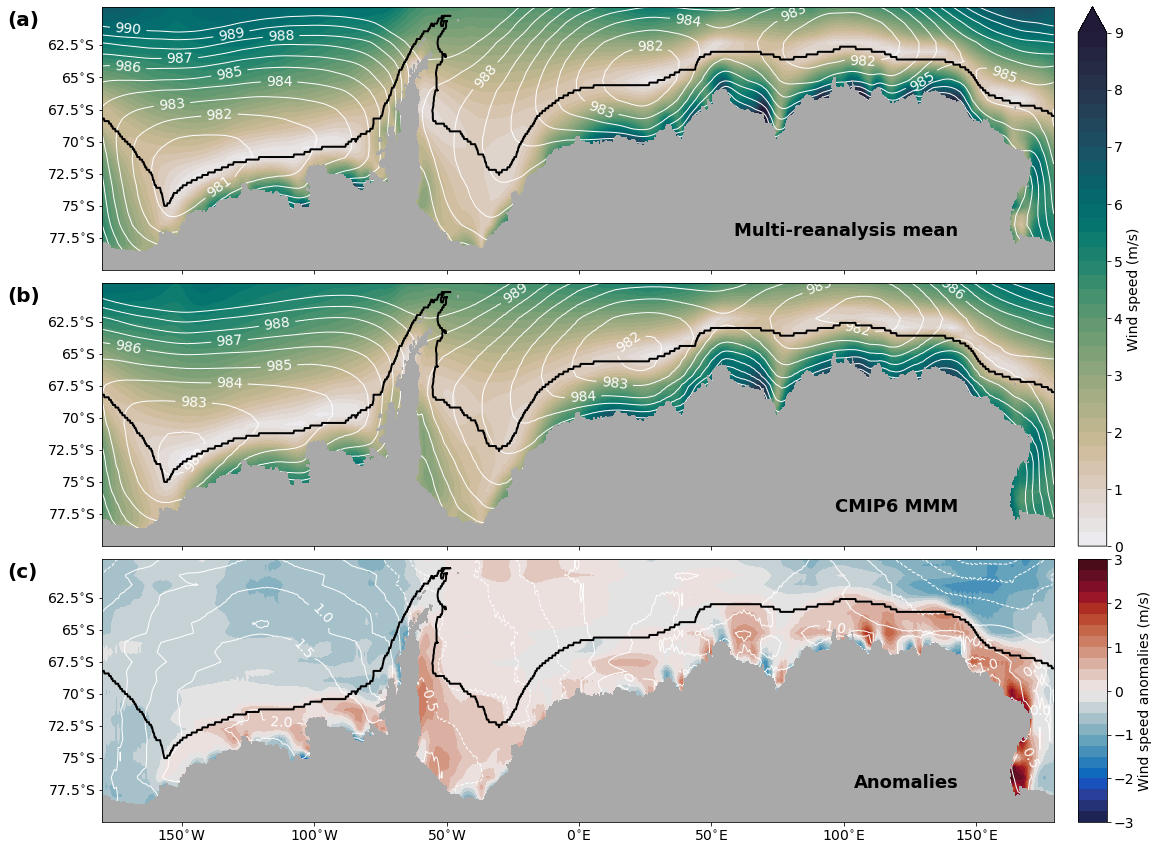

In [ ]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 15))
gr = gs.GridSpec(3, 2, figure = fig, width_ratios = [1, .03], 
                 hspace = .05, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]), fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]), fig.add_subplot(gr[:2,1]), 
       fig.add_subplot(gr[2,1])]
for ax, label in zip(axs[:-2], ['(a)', '(b)', '(c)']):
    ax.text(-0.1, .93, label, transform = ax.transAxes, size = 20, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', 
                        '70$^{\circ}$S', '67.5$^{\circ}$S', '65$^{\circ}$S', 
                        '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', 
                            '0$^{\circ}$E',  '50$^{\circ}$E', '100$^{\circ}$E', 
                            '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'darkgrey', linewidths = 0.5, 
                zorder = 2)
    ax.plot(div_lin[0], div_lin[1], 'k', linewidth = 2, zorder = 2)

axs[0].text(0.9, .13, 'Multi-reanalysis mean', horizontalalignment = 'right', transform = axs[0].transAxes, size = 18, weight = 'bold')
axs[1].text(0.9, .13, 'CMIP6 MMM', horizontalalignment = 'right', transform = axs[1].transAxes, size = 18, weight = 'bold')
axs[2].text(0.9, .13, 'Anomalies', horizontalalignment = 'right', transform = axs[2].transAxes, size = 18, weight = 'bold')

# Reanalysis
k = 'reanalysis'
c1 = axs[0].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k], 
                    levels = np.arange(0, 9.25, .25), extend = 'max',
                    cmap = cmocean.cm.rain, zorder = 0)
cbar = fig.colorbar(c1, cax = axs[-2])
cbar.set_label('Wind speed (m/s)')
c = axs[0].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100,
                   levels = np.arange(950, 991, 1), colors = ['white'], 
                   linewidths = [1], zorder = 1)
axs[0].clabel(c, c.levels, inline=True, fmt='%1.0f', fontsize=14, zorder = 1)
# CMIP6
k = 'cmip6'
c = axs[1].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k], 
                    levels = np.arange(0, 9.25, .25), extend = 'max',
                    cmap = cmocean.cm.rain, zorder = 0)
c = axs[1].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100,
                   levels = np.arange(950, 991, 1), colors = ['white'], 
                   linewidths = [1], zorder = 1)
axs[1].clabel(c, c.levels, inline = True, fmt='%1.0f', fontsize=14, zorder = 1)
# CMIP6 anomalies
c = axs[2].contourf(wsp[k]['lon'], wsp[k]['lat'], wsp[k]-wsp['reanalysis'], 
                    levels = np.arange(-3, 3.25, .25), 
                    cmap = cmocean.cm.balance, zorder = 0)
cbar = fig.colorbar(c, cax = axs[-1])
cbar.set_ticks(np.arange(-3, 4, 1))
cbar.set_label('Wind speed anomalies (m/s)')
c = axs[2].contour(psl[k]['lon'], psl[k]['lat'], psl[k]/100-psl['reanalysis']/100,
                   levels = np.arange(-2.5, 2.5, .5), colors = ['white'], 
                   linewidths = [1], zorder = 1)
axs[2].clabel(c, c.levels, inline = True, fmt='%1.1f', fontsize = 14, zorder = 1)

plt.savefig('../results/v6/fig1.jpg', bbox_inches = 'tight', dpi = 800)